In [1]:
#%% [Block 0: Imports & Setup]
import os, json, math, warnings, logging, sys
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
# Optional: XGBoost (guarded import)
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

import joblib
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.random.seed(42)

# Logging setup (console + file)
LOG_DIR = "ml_artifacts"
os.makedirs(LOG_DIR, exist_ok=True)
logfile = os.path.join(LOG_DIR, f"k2_train_{datetime.now().strftime('%Y%m%d-%H%M%S')}.log")

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[
        logging.StreamHandler(stream=sys.stdout), 
        logging.FileHandler(logfile, encoding="utf-8")
    ],
    force=True, 
)
log = logging.getLogger("K2-Exo")
log.info("Environment initialized. XGBoost available: %s", HAS_XGB)

2025-10-03 08:00:10,853 | INFO | Environment initialized. XGBoost available: True


In [6]:
#%% [Block 1: Config]
CSV_PATH = r"E:\Nasa Space App 2025\Hunting_For_Exoplanets_With_AI_Nasa2025\DataSet\K2\K2_train.csv"
SELECT_K = 40  # initial cap; will be validated after preprocessing fit
MIN_ONEHOT_FREQ = 10  # to constrain OHE explosion
TEST_SIZE = 0.2
N_SPLITS = 5
RANDOM_STATE = 42

LABEL_SET = ["CANDIDATE", "CONFIRMED", "FALSE POSITIVE"]
LABEL_TO_ID = {lab: i for i, lab in enumerate(LABEL_SET)}
ID_TO_LABEL = {v: k for k, v in LABEL_TO_ID.items()}

ARTIFACT_PREFIX = "k2_exo"

In [8]:
#%% [Block 2: Utility functions]
def json_safe(x):
    """Make common numpy/scikit objects JSON serializable."""
    if isinstance(x, np.generic):
        return x.item()
    if isinstance(x, np.ndarray):
        return x.tolist()
    if isinstance(x, dict):
        return {k: json_safe(v) for k, v in x.items()}
    if isinstance(x, (list, tuple)):
        return [json_safe(v) for v in x]
    return x

def plot_confusion_matrix(cm, labels, title, save_path=None):
    fig, ax = plt.subplots(figsize=(7,5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(title, fontweight="bold")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

In [9]:
#%% [Block 3: Load & normalize labels]
log.info("Loading CSV from %s", CSV_PATH)
df = pd.read_csv(CSV_PATH, comment="#", low_memory=False)

df["disposition_norm"] = (
    df["disposition"].astype(str).str.strip().str.upper().str.replace("_", " ")
)
df = df[df["disposition_norm"].isin(LABEL_SET)].copy()
df["y"] = df["disposition_norm"].map(LABEL_TO_ID).astype(int)

class_counts = df["disposition_norm"].value_counts().to_dict()
log.info("Class distribution: %s", class_counts)

2025-10-03 08:01:02,321 | INFO | Loading CSV from E:\Nasa Space App 2025\Hunting_For_Exoplanets_With_AI_Nasa2025\DataSet\K2\K2_train.csv
2025-10-03 08:01:02,461 | INFO | Class distribution: {'CONFIRMED': 2208, 'CANDIDATE': 1369, 'FALSE POSITIVE': 293}


In [11]:
df.head(10)

,pl_name,hostname,default_flag,disposition,disp_refname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,...,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate,disposition_norm,y
0,BD+20 594 b,BD+20 594,0,CONFIRMED,Espinoza et al. 2016,1.0,1.0,Transit,2016.0,K2,...,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2018-03,2018-02-15,CONFIRMED,1
1,BD+20 594 b,BD+20 594,0,CONFIRMED,Espinoza et al. 2016,1.0,1.0,Transit,2016.0,K2,...,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2016-10,2016-07-28,CONFIRMED,1
2,BD+20 594 b,BD+20 594,1,CONFIRMED,Espinoza et al. 2016,1.0,1.0,Transit,2016.0,K2,...,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2017-03,2018-04-26,CONFIRMED,1
3,EPIC 201111557.01,EPIC 201111557,0,CANDIDATE,Livingston et al. 2018,1.0,0.0,Transit,2018.0,K2,...,0.019,-0.019,11.3995,0.001307,-0.001307,2018-02-15,2018-03,2018-02-15,CANDIDATE,0
4,EPIC 201111557.01,EPIC 201111557,1,CANDIDATE,Livingston et al. 2018,1.0,0.0,Transit,2018.0,K2,...,0.019,-0.019,11.3995,0.001307,-0.001307,2018-08-02,2018-08,2018-08-02,CANDIDATE,0
5,EPIC 201126503.01,EPIC 201126503,1,CANDIDATE,Vanderburg et al. 2016,1.0,0.0,Transit,2016.0,K2,...,0.070,-0.070,17.8892,0.001662,-0.001662,2015-12-05,2016-01,2015-12-05,CANDIDATE,0
6,EPIC 201127519.01,EPIC 201127519,0,CANDIDATE,Livingston et al. 2018,1.0,0.0,Transit,2018.0,K2,...,0.021,-0.021,11.4806,0.000478,-0.000478,2018-02-15,2018-03,2018-02-15,CANDIDATE,0
7,EPIC 201127519.01,EPIC 201127519,1,CANDIDATE,Livingston et al. 2018,1.0,0.0,Transit,2018.0,K2,...,0.021,-0.021,11.4806,0.000478,-0.000478,2018-08-02,2018-08,2018-08-02,CANDIDATE,0
8,EPIC 201147085.01,EPIC 201147085,1,CANDIDATE,Kruse et al. 2019,1.0,0.0,Transit,2019.0,K2,...,0.023,-0.023,NaN,NaN,NaN,2019-09-05,2019-09,2019-09-05,CANDIDATE,0
9,EPIC 201152065.01,EPIC 201152065,1,CANDIDATE,Kruse et al. 2019,1.0,0.0,Transit,2019.0,K2,...,0.023,-0.023,13.9562,0.000535,-0.000535,2019-09-05,2019-09,2019-09-05,CANDIDATE,0


In [12]:
#%% [Block 4: Feature engineering]
def add_k2_features(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    if {"pl_rade","pl_radj"}.issubset(out.columns):
        denom = (out["pl_radj"] * 11.209).replace(0, np.nan)
        out["radius_consistency"] = out["pl_rade"] / denom
    if {"pl_bmasse","pl_rade"}.issubset(out.columns):
        denom = (out["pl_rade"]**3).replace(0, np.nan)
        out["bulk_density_proxy"] = out["pl_bmasse"] / denom
    if {"pl_orbper","pl_orbsmax"}.issubset(out.columns):
        denom = (out["pl_orbsmax"]**3).replace(0, np.nan)
        out["kepler_ratio"] = (out["pl_orbper"]**2) / denom
    if {"pl_eqt","st_teff"}.issubset(out.columns):
        denom = out["st_teff"].replace(0, np.nan)
        out["temp_ratio"] = out["pl_eqt"] / denom
    if "pl_insol" in out.columns:
        out["log_insol"] = np.log10(out["pl_insol"].clip(lower=0) + 1)
    if {"st_mass","st_rad"}.issubset(out.columns):
        denom = (out["st_rad"]**3).replace(0, np.nan)
        out["stellar_density_proxy"] = out["st_mass"] / denom
    if "sy_dist" in out.columns:
        out["log_distance"] = np.log10(out["sy_dist"].clip(lower=0) + 1)
    if "pl_orbper" in out.columns:
        out["log_period"] = np.log10(out["pl_orbper"].clip(lower=0) + 1)
    return out.replace([np.inf, -np.inf], np.nan)

df = add_k2_features(df)
log.info("Feature engineering complete. Current columns: %d", df.shape[1])

2025-10-03 08:01:33,734 | INFO | Feature engineering complete. Current columns: 104


In [13]:
#%% [Block 5: Feature lists & grouping]
base_numeric = [
    'sy_snum','sy_pnum','pl_orbper','pl_orbsmax','pl_rade','pl_radj','pl_bmasse','pl_bmassj',
    'pl_orbeccen','pl_insol','pl_eqt','st_teff','st_rad','st_mass','st_met','st_logg',
    'ra','dec','sy_dist','sy_vmag','sy_kmag','sy_gaiamag',
    'radius_consistency','bulk_density_proxy','kepler_ratio','temp_ratio',
    'log_insol','stellar_density_proxy','log_distance','log_period'
]
context_num = [c for c in ["default_flag","pl_controv_flag","ttv_flag","disc_year"] if c in df.columns]
context_cat = [c for c in ["discoverymethod","disc_facility","st_spectype","pl_bmassprov"] if c in df.columns]

numeric_features = [c for c in base_numeric + context_num if c in df.columns]
categorical_features = [c for c in context_cat if c in df.columns]

if "hostname" in df.columns:
    groups = df["hostname"].astype(str).values
else:
    ra_bin = (df["ra"]*1000).round().astype("Int64") if "ra" in df.columns else 0
    dec_bin = (df["dec"]*1000).round().astype("Int64") if "dec" in df.columns else 0
    groups = (ra_bin.astype(str) + "_" + dec_bin.astype(str)).values

X_all = df[numeric_features + categorical_features].copy()
y_all = df["y"].values

log.info("Numeric features: %d | Categorical: %d", len(numeric_features), len(categorical_features))


2025-10-03 08:01:40,406 | INFO | Numeric features: 34 | Categorical: 4


In [10]:
#%% [Block 6: Group-aware train/test split]
gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X_all, y_all, groups=groups))
X_train, X_test = X_all.iloc[train_idx].copy(), X_all.iloc[test_idx].copy()
y_train, y_test = y_all[train_idx], y_all[test_idx]
groups_train, groups_test = groups[train_idx], groups[test_idx]

log.info("Split done. Train: %d | Test: %d", X_train.shape[0], X_test.shape[0])

2025-10-02 17:06:05,066 | INFO | Split done. Train: 3071 | Test: 799


In [11]:
#%% [Block 7: Preprocessing & class weights]
numeric_transformer = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=True, with_std=True))
])

categorical_transformer = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=MIN_ONEHOT_FREQ))
])

preproc = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

counts = Counter(y_train)
n_classes = len(set(y_train))
total = sum(counts.values())
class_weight = {cls: total/(n_classes*cnt) for cls, cnt in counts.items()}
log.info("Class weights: %s", class_weight)

# Helper to build a safe k for SelectKBest after we know feature count
def make_select_k(k_cap, preprocessor, X_sample):
    # Fit a small preprocessor to get transformed feature count
    Z = preprocessor.fit_transform(X_sample.iloc[:200].copy())  # sample for speed
    feat_count = Z.shape[1]
    k = min(max(10, k_cap), feat_count)  # ensure 10 <= k <= feat_count
    log.info("SelectKBest | Transformed features=%d | Using k=%d", feat_count, k)
    return SelectKBest(score_func=f_classif, k=k)


def print_progress_block(model_name, acc, cv_mean, cv_std, auc_macro, report_text, cm_array):
    line = "─" * 72
    print(f"\n🤖 Block 8: Pipelines & Evaluation (Multiclass)\n")
    print("\n✅ Results")
    print(f"   🎯 Accuracy                : {acc:.4f}")
    print(f"   📊 CV F1-macro (train-only): {cv_mean:.4f} (+/- {cv_std:.4f})")
    print(f"   📈 ROC AUC (OVR, macro)    : {auc_macro if auc_macro is not None else 'N/A'}")
    print("\n   🧾 Per-class report:")
    print(report_text)
    print("\n   🔢 Confusion matrix:")
    print(np.array(cm_array))
    print(line)


2025-10-02 17:06:08,627 | INFO | Class weights: {np.int64(1): 0.5879762588550641, np.int64(0): 0.9434715821812596, np.int64(2): 4.178231292517006}


2025-10-02 17:06:20,537 | INFO | SelectKBest | Transformed features=39 | Using k=39
2025-10-02 17:06:20,591 | INFO | SelectKBest | Transformed features=39 | Using k=39
2025-10-02 17:06:20,645 | INFO | SelectKBest | Transformed features=39 | Using k=39
2025-10-02 17:06:20,748 | INFO | SelectKBest | Transformed features=39 | Using k=39
2025-10-02 17:06:20,794 | INFO | SelectKBest | Transformed features=39 | Using k=39

🔄 Training Random Forest...

🤖 Block 8: Pipelines & Evaluation (Multiclass)


✅ Results
   🎯 Accuracy                : 0.9599
   📊 CV F1-macro (train-only): 0.8667 (+/- 0.1011)
   📈 ROC AUC (OVR, macro)    : 0.9906940340289453

   🧾 Per-class report:
                precision    recall  f1-score   support

     CANDIDATE       0.93      0.95      0.94       284
     CONFIRMED       0.99      1.00      0.99       467
FALSE POSITIVE       0.78      0.60      0.68        48

      accuracy                           0.96       799
     macro avg       0.90      0.85      0.87 

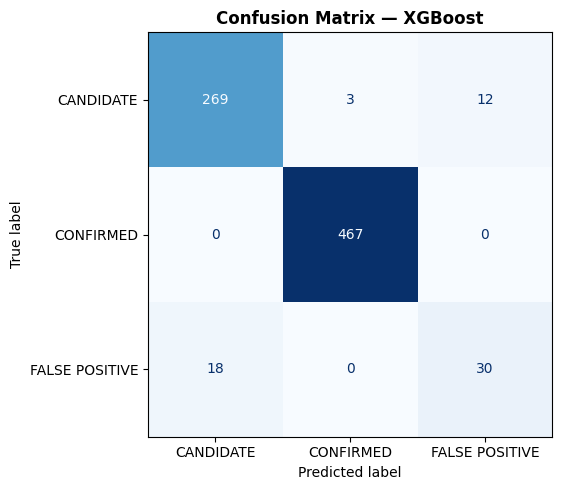

2025-10-02 17:07:21,031 | INFO | Block 10: Model Optimization via GridSearchCV (XGBoost)


In [12]:
#%% [Block 8: Model pipelines & training — Pretty Progress Printing]
from sklearn.base import clone

def make_pipe(clf):
    return Pipeline([
        ("pre", preproc),
        ("sel", make_select_k(SELECT_K, preproc, X_train)),
        ("clf", clf)
    ])

models = {}

models["Random Forest"] = make_pipe(
    RandomForestClassifier(
        n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1,
        class_weight="balanced_subsample", verbose=0
    )
)

models["Gradient Boosting"] = make_pipe(
    GradientBoostingClassifier(random_state=RANDOM_STATE, verbose=0)
)

models["Logistic Regression"] = make_pipe(
    LogisticRegression(
        random_state=RANDOM_STATE, max_iter=4000,
        class_weight=class_weight, multi_class="auto", solver="lbfgs"
    )
)

models["SVM"] = make_pipe(
    SVC(
        random_state=RANDOM_STATE, probability=True,
        class_weight=class_weight, kernel="rbf", gamma="scale", verbose=False
    )
)

if HAS_XGB:
    models["XGBoost"] = make_pipe(
        XGBClassifier(
            random_state=RANDOM_STATE, n_estimators=600, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            objective="multi:softprob", eval_metric="mlogloss", n_jobs=-1,
            verbosity=0
        )
    )

gkf = GroupKFold(n_splits=N_SPLITS)
results = {}

for name, pipe in models.items():
    print(f"\n🔄 Training {name}...")
    # Grouped CV: F1-macro
    cv_scores = cross_val_score(
        pipe,
        X_train, y_train,
        cv=gkf.split(X_train, y_train, groups=groups_train),
        scoring="f1_macro",
        n_jobs=-1
    )
    cv_mean = float(cv_scores.mean())
    cv_std = float(cv_scores.std())

    # Fit on full train
    pipe.fit(X_train, y_train)

    # Test predictions
    y_pred = pipe.predict(X_test)

    # AUC (macro OVR)
    auc_macro = None
    try:
        if hasattr(pipe, "predict_proba"):
            proba = pipe.predict_proba(X_test)
            if isinstance(proba, np.ndarray) and proba.ndim == 2:
                auc_macro = float(roc_auc_score(y_test, proba, multi_class="ovr", average="macro"))
        elif hasattr(pipe, "decision_function"):
            s = pipe.decision_function(X_test)
            if isinstance(s, np.ndarray) and s.ndim == 2:
                auc_macro = float(roc_auc_score(y_test, s, multi_class="ovr", average="macro"))
    except Exception:
        auc_macro = None

    acc = float((y_pred == y_test).mean())
    f1m = float(f1_score(y_test, y_pred, average="macro"))
    report_txt = classification_report(y_test, y_pred, target_names=LABEL_SET)
    cm = confusion_matrix(y_test, y_pred)

    # Pretty progress print (exact style you showed)
    print_progress_block(
        model_name=name,
        acc=acc,
        cv_mean=cv_mean,
        cv_std=2*cv_std,  # print ±2σ like your example
        auc_macro=auc_macro,
        report_text=report_txt,
        cm_array=cm
    )

    # Keep results for later blocks
    results[name] = {
        "pipeline": pipe,
        "accuracy": acc,
        "f1_macro": f1m,
        "cv_f1_macro": cv_mean,
        "cv_f1_macro_std": cv_std,
        "auc_macro_ovr": auc_macro,
        "cm": cm.tolist()
    }


#%% [Block 9: Model Comparison & Best Selection]
log.info("Block 9: Model Comparison and Best Model Selection")

comparison_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Test Accuracy": [v["accuracy"] for v in results.values()],
    "CV F1-macro (mean)": [v["cv_f1_macro"] for v in results.values()],
    "CV F1-macro (±2σ)": [v["cv_f1_macro_std"] * 2 for v in results.values()],
    "ROC AUC (OVR, macro)": [v["auc_macro_ovr"] for v in results.values()],
}).sort_values("CV F1-macro (mean)", ascending=False)

with pd.option_context("display.max_columns", None, "display.width", 160):
    print("\n=== Model Comparison ===")
    print(comparison_df.round(4).to_string(index=False))

best_model_name = comparison_df.iloc[0]["Model"]
best_info = results[best_model_name]
best_pipe = best_info["pipeline"]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   CV F1-macro (mean): {best_info['cv_f1_macro']:.4f}")
print(f"   Test Accuracy      : {best_info['accuracy']:.4f}")
print(f"   ROC AUC (OVR, macro): {best_info['auc_macro_ovr'] if best_info['auc_macro_ovr'] is not None else 'N/A'}")

# Detailed report & confusion matrix for best
y_pred_best = best_pipe.predict(X_test)
print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=LABEL_SET))

cm_best = confusion_matrix(y_test, y_pred_best)
plot_confusion_matrix(cm_best, LABEL_SET, f"Confusion Matrix — {best_model_name}",
                      save_path=os.path.join(LOG_DIR, f"cm_{best_model_name}.png"))

#%% [Block 10: Grid Search on the Best Pipeline]
log.info("Block 10: Model Optimization via GridSearchCV (%s)", best_model_name)

2025-10-02 17:08:23,983 | INFO | Block 10: Model Optimization via GridSearchCV (XGBoost)
2025-10-02 17:08:23,987 | INFO | Tuning params: {
  "sel__k": [
    20,
    30,
    38
  ],
  "clf__n_estimators": [
    300,
    500
  ],
  "clf__learning_rate": [
    0.05,
    0.1
  ],
  "clf__max_depth": [
    4,
    6
  ],
  "clf__subsample": [
    0.8,
    1.0
  ],
  "clf__colsample_bytree": [
    0.8,
    1.0
  ]
}
2025-10-02 17:08:24,014 | INFO | SelectKBest | Transformed features=39 | Using k=39
Fitting 5 folds for each of 96 candidates, totalling 480 fits
2025-10-02 17:14:44,531 | INFO | Grid Search complete. Best params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 300, 'clf__subsample': 1.0, 'sel__k': 38}
2025-10-02 17:14:44,533 | INFO | Best CV F1-macro: 0.8904

=== Optimized Model — Test ===
 Accuracy  : 0.9625
 F1-macro  : 0.8736
 ROC AUC   : 0.9885637087658236


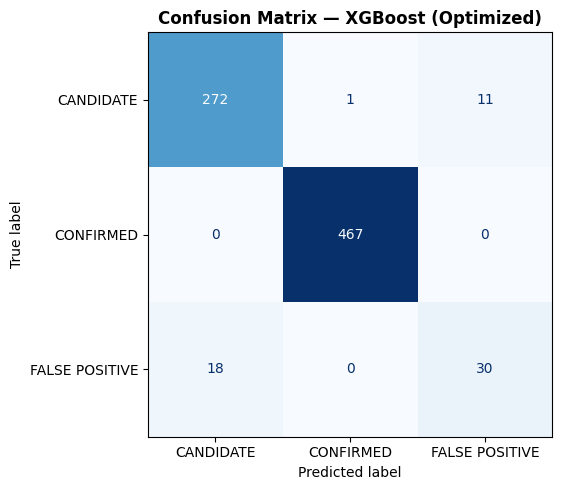

In [13]:
#%% [Block 10: Grid Search on the Best Pipeline]
log.info("Block 10: Model Optimization via GridSearchCV (%s)", best_model_name)

# Rebuild a fresh pipe with a fresh selector (so GridSearch can change k reliably)
def rebuild_best_pipe(name):
    base = None
    if name == "Random Forest":
        base = RandomForestClassifier(
            n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1,
            class_weight="balanced_subsample"
        )
    elif name == "Gradient Boosting":
        base = GradientBoostingClassifier(random_state=RANDOM_STATE)
    elif name == "Logistic Regression":
        base = LogisticRegression(
            random_state=RANDOM_STATE, max_iter=4000,
            class_weight=class_weight, multi_class="auto", solver="lbfgs"
        )
    elif name == "SVM":
        base = SVC(
            random_state=RANDOM_STATE, probability=True,
            class_weight=class_weight, kernel="rbf", gamma="scale"
        )
    elif name == "XGBoost" and HAS_XGB:
        base = XGBClassifier(
            random_state=RANDOM_STATE, n_estimators=600, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            objective="multi:softprob", eval_metric="mlogloss", n_jobs=-1
        )
    else:
        raise ValueError(f"Unknown/unsupported model for rebuild: {name}")

    # fresh selector; k will be replaced by GridSearch param
    sel = make_select_k(SELECT_K, preproc, X_train)
    return Pipeline([("pre", preproc), ("sel", sel), ("clf", base)])

base_param_grid = {
    "sel__k": [
        min(20, X_train.shape[1]),
        min(30, X_train.shape[1]),
        min(40, X_train.shape[1])
    ]
}

if best_model_name == "Random Forest":
    param_grid = {
        **base_param_grid,
        "clf__n_estimators": [300, 500],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [1, 2],
    }
elif best_model_name == "Gradient Boosting":
    param_grid = {
        **base_param_grid,
        "clf__n_estimators": [200, 400],
        "clf__learning_rate": [0.05, 0.1],
        "clf__max_depth": [3, 5],
    }
elif best_model_name == "Logistic Regression":
    param_grid = {
        **base_param_grid,
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l2"],
    }
elif best_model_name == "SVM":
    param_grid = {
        **base_param_grid,
        "clf__C": [0.5, 1, 5],
        "clf__kernel": ["rbf", "poly"],
        "clf__gamma": ["scale", "auto"],
    }
elif best_model_name == "XGBoost" and HAS_XGB:
    param_grid = {
        **base_param_grid,
        "clf__n_estimators": [300, 500],
        "clf__learning_rate": [0.05, 0.1],
        "clf__max_depth": [4, 6],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0],
    }
else:
    param_grid = base_param_grid

log.info("Tuning params: %s", json.dumps(param_grid, indent=2))

opt_search = GridSearchCV(
    estimator=rebuild_best_pipe(best_model_name),
    param_grid=param_grid,
    scoring="f1_macro",
    cv=gkf.split(X_train, y_train, groups=groups_train),
    n_jobs=-1,
    verbose=1
)

opt_search.fit(X_train, y_train)
log.info("Grid Search complete. Best params: %s", opt_search.best_params_)
log.info("Best CV F1-macro: %.4f", opt_search.best_score_)

opt_pipe = opt_search.best_estimator_

# Evaluate optimized pipeline on test
y_pred_opt = opt_pipe.predict(X_test)

opt_auc = np.nan
try:
    if hasattr(opt_pipe, "predict_proba"):
        p = opt_pipe.predict_proba(X_test)
        if isinstance(p, np.ndarray) and p.ndim == 2:
            opt_auc = roc_auc_score(y_test, p, multi_class="ovr", average="macro")
    elif hasattr(opt_pipe, "decision_function"):
        s = opt_pipe.decision_function(X_test)
        if isinstance(s, np.ndarray) and s.ndim == 2:
            opt_auc = roc_auc_score(y_test, s, multi_class="ovr", average="macro")
except Exception as e:
    log.warning("AUC for optimized model failed: %s", e)

opt_acc = float((y_pred_opt == y_test).mean())
opt_f1m = float(f1_score(y_test, y_pred_opt, average="macro"))

print("\n=== Optimized Model — Test ===")
print(f" Accuracy  : {opt_acc:.4f}")
print(f" F1-macro  : {opt_f1m:.4f}")
print(f" ROC AUC   : {opt_auc if not np.isnan(opt_auc) else 'N/A'}")

cm_opt = confusion_matrix(y_test, y_pred_opt)
plot_confusion_matrix(cm_opt, LABEL_SET, f"Confusion Matrix — {best_model_name} (Optimized)",
                      save_path=os.path.join(LOG_DIR, f"cm_{best_model_name}_optimized.png"))

# Selected features after SelectKBest
try:
    # resolve feature names after preprocessing
    # Fit preproc on all train to get OHE categories and names
    preproc_fitted = opt_pipe.named_steps["pre"]
    if not hasattr(preproc_fitted, "transformers_"):
        preproc_fitted.fit(X_train)

    feature_names_pre = []
    # numeric names
    feature_names_pre.extend(list(preproc_fitted.transformers_[0][2]))  # from numeric_features
    # categorical names via OHE
    if len(categorical_features) > 0:
        ohe = preproc_fitted.named_transformers_["cat"].named_steps["onehot"]
        cat_expanded = ohe.get_feature_names_out(categorical_features).tolist()
        feature_names_pre.extend(cat_expanded)

    selector = opt_pipe.named_steps["sel"]
    if hasattr(selector, "get_support"):
        mask = selector.get_support()
        selected_feature_names = [f for f, m in zip(feature_names_pre, mask) if m]
    else:
        selected_feature_names = feature_names_pre
except Exception as e:
    log.warning("Failed to retrieve selected feature names: %s", e)
    selected_feature_names = numeric_features + categorical_features



In [17]:
#%% [Block 11: Save Artifacts & Metadata]
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
pipeline_path = os.path.join(LOG_DIR, f"k2_best_traditional_{best_model_name}.joblib")
joblib.dump(opt_pipe, pipeline_path)

feat_path = os.path.join(LOG_DIR, f"selected_features.json")
with open(feat_path, "w") as f:
    json.dump(selected_feature_names, f, indent=2)

# Compile results (metrics only) minus actual pipeline objects
results_metrics_only = {}
for model_name, info in results.items():
    metrics = {k: v for k, v in info.items() if k != "pipeline"}
    results_metrics_only[model_name] = json_safe(metrics)

meta = {
    "best_model": best_model_name,
    "label_set": json_safe(opt_search.best_params_),
    "cv_f1_macro": float(opt_search.best_score_),
    "test_accuracy": float(opt_acc),
    "test_f1_macro": float(opt_f1m),
    "test_auc_ovr_macro": None if np.isnan(opt_auc) else float(opt_auc),
    "n_selected_features": len(selected_feature_names),
    "label_set": LABEL_SET,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "results_by_model": results_metrics_only,
    "created_at": timestamp,
}
meta_path = os.path.join(LOG_DIR, f"metadata.json")
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

print("\nSaved:")
print("  • Pipeline :", pipeline_path)
print("  • Features :", feat_path)
print("  • Metadata :", meta_path)
print("  • Logs     :", logfile)


Saved:
  • Pipeline : ml_artifacts\k2_best_traditional_XGBoost.joblib
  • Features : ml_artifacts\selected_features.json
  • Metadata : ml_artifacts\metadata.json
  • Logs     : ml_artifacts\k2_train_20251002-170546.log


# Prediction

In [19]:
# === K2 Traditional ML — Jupyter prediction cell (row-selectable or full CSV) ===
# Prereqs: you already ran train_k2_traditional_ml.py and have:
#   ml_artifacts/metadata.json
#   ml_artifacts/k2_best_traditional_<BestName>.joblib
#
# How to use:
#   1) Set CSV_PATH as needed (the file you want to score).
#   2) Run this cell.
#   3) Examples:
#        df_sel = predict_rows([1,2,3,4,5], save_path="ml_row_preds.csv")
#        df_all = predict_csv(save_path="ml_full_preds.csv")

import os, json, math, warnings
from typing import List, Dict, Optional
import numpy as np
import pandas as pd
import joblib

warnings.filterwarnings("ignore")

# --------- User config ----------
CSV_PATH = r"E:\Nasa Space App 2025\Hunting_For_Exoplanets_With_AI_Nasa2025\DataSet\K2\fast_100_rows.csv"
ART_DIR  = "ml_artifacts"   # where metadata.json + joblib live
# --------------------------------

# ---------- Utils (match training) ----------
def add_k2_features(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    if {"pl_rade","pl_radj"}.issubset(out.columns):
        denom = (out["pl_radj"] * 11.209).replace(0, np.nan)
        out["radius_consistency"] = out["pl_rade"] / denom
    if {"pl_bmasse","pl_rade"}.issubset(out.columns):
        denom = (out["pl_rade"]**3).replace(0, np.nan)
        out["bulk_density_proxy"] = out["pl_bmasse"] / denom
    if {"pl_orbper","pl_orbsmax"}.issubset(out.columns):
        denom = (out["pl_orbsmax"]**3).replace(0, np.nan)
        out["kepler_ratio"] = (out["pl_orbper"]**2) / denom
    if {"pl_eqt","st_teff"}.issubset(out.columns):
        denom = out["st_teff"].replace(0, np.nan)
        out["temp_ratio"] = out["pl_eqt"] / denom
    if "pl_insol" in out.columns:
        out["log_insol"] = np.log10(out["pl_insol"].clip(lower=0) + 1)
    if {"st_mass","st_rad"}.issubset(out.columns):
        denom = (out["st_rad"]**3).replace(0, np.nan)
        out["stellar_density_proxy"] = out["st_mass"] / denom
    if "sy_dist" in out.columns:
        out["log_distance"] = np.log10(out["sy_dist"].clip(lower=0) + 1)
    if "pl_orbper" in out.columns:
        out["log_period"] = np.log10(out["pl_orbper"].clip(lower=0) + 1)
    return out.replace([np.inf,-np.inf], np.nan)

def choose_id_columns(df: pd.DataFrame) -> List[str]:
    candidates = [
        "kepid","koi_name","koi_disposition",
        "epic","epicid","epic_name","pl_name",
        "hostname","tic_id","ticid","rowid"
    ]
    return [c for c in candidates if c in df.columns]

# ---------- Load artifacts ----------
meta_path = os.path.join(ART_DIR, "metadata.json")
if not os.path.exists(meta_path):
    raise FileNotFoundError(f"Missing metadata.json in {ART_DIR}")
with open(meta_path, "r") as f:
    META = json.load(f)

LABEL_SET: List[str] = META["label_set"]
NUMERIC_FEATURES: List[str] = META["numeric_features"]
CATEGORICAL_FEATURES: List[str] = META["categorical_features"]
BEST_NAME: str = META["best_model"]

joblib_path_guess = os.path.join(ART_DIR, f"k2_best_traditional_{BEST_NAME}.joblib")
if not os.path.exists(joblib_path_guess):
    # fallback: pick any .joblib if naming changed
    cands = [os.path.join(ART_DIR, f) for f in os.listdir(ART_DIR) if f.endswith(".joblib")]
    if not cands:
        raise FileNotFoundError(f"No .joblib found in {ART_DIR}")
    joblib_path = cands[0]
else:
    joblib_path = joblib_path_guess

print(f"📦 Loading pipeline: {joblib_path}")
PIPE = joblib.load(joblib_path)

# ---------- Load CSV once ----------
FULL_DF = pd.read_csv(CSV_PATH, low_memory=False)

# ---------- Core predictor helpers ----------
def _prepare_features(df_in: pd.DataFrame) -> pd.DataFrame:
    """Add engineered features and select only the columns the pipeline expects."""
    df_feat = add_k2_features(df_in.copy())
    # Ensure all expected columns exist
    for c in NUMERIC_FEATURES + CATEGORICAL_FEATURES:
        if c not in df_feat.columns:
            # numeric missing -> NaN; categorical missing -> "UNK"
            df_feat[c] = np.nan if c in NUMERIC_FEATURES else "UNK"
    # Keep only expected columns in proper order
    df_feat = df_feat[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
    return df_feat

def _predict_df(df_in: pd.DataFrame, batch_size: Optional[int] = None):
    X = _prepare_features(df_in)
    # Predictions
    y_idx = PIPE.predict(X)
    # Probabilities (if available)
    proba = None
    if hasattr(PIPE, "predict_proba"):
        try:
            proba = PIPE.predict_proba(X)
        except Exception:
            proba = None
    # Map to labels
    y_lab = [LABEL_SET[i] for i in y_idx]
    return y_idx, y_lab, proba

def predict_rows(rows_1based: List[int], save_path: Optional[str] = None) -> pd.DataFrame:
    """Predict for specific 1-based row numbers from FULL_DF."""
    if not rows_1based:
        raise ValueError("Provide at least one row number (1-based).")
    idx0 = [r-1 for r in rows_1based]
    max_i = len(FULL_DF) - 1
    bad = [i for i in idx0 if i < 0 or i > max_i]
    if bad:
        raise IndexError(f"Row(s) out of range 0..{max_i} (zero-based): {bad} (remember you pass 1-based)")

    df_sel = FULL_DF.iloc[idx0].copy()
    y_idx, y_lab, proba = _predict_df(df_sel)

    # Build output
    id_cols = choose_id_columns(df_sel)
    out = pd.DataFrame(index=df_sel.index)
    if id_cols:
        out[id_cols] = df_sel[id_cols]
    out["row_number_1based"] = out.index + 1
    out["pred_index"] = y_idx
    out["pred_label"] = y_lab

    if isinstance(proba, np.ndarray) and proba.ndim == 2 and proba.shape[1] == len(LABEL_SET):
        for i, lab in enumerate(LABEL_SET):
            out[f"prob_{lab.replace(' ','_').lower()}"] = proba[:, i]
        out["pred_confidence"] = out[[f"prob_{lab.replace(' ','_').lower()}" for lab in LABEL_SET]].max(axis=1)

    # Nicely ordered columns
    front = (id_cols + ["row_number_1based","pred_label","pred_index"])
    if "pred_confidence" in out.columns:
        front += ["pred_confidence"]
    rest = [c for c in out.columns if c not in front]
    out = out[front + rest]

    if save_path:
        out.to_csv(save_path, index=False)
        print(f"✅ Saved predictions for rows {rows_1based} → {save_path}")

    # Preview
    show_cols = [c for c in ["row_number_1based"] + id_cols + ["pred_label","pred_confidence"] if c in out.columns]
    print(out[show_cols].to_string(index=False))
    return out

def predict_csv(in_csv: Optional[str] = None, save_path: Optional[str] = None, chunk_size: Optional[int] = None) -> pd.DataFrame:
    """
    Predict for an entire CSV (defaulting to CSV_PATH).
    Optionally stream in chunks to reduce memory (no shuffling; concatenates outputs).
    """
    path = in_csv or CSV_PATH
    if chunk_size is None:
        df = pd.read_csv(path, low_memory=False)
        y_idx, y_lab, proba = _predict_df(df)

        id_cols = choose_id_columns(df)
        out = pd.DataFrame(index=df.index)
        if id_cols:
            out[id_cols] = df[id_cols]
        out["row_number_1based"] = out.index + 1
        out["pred_index"] = y_idx
        out["pred_label"] = y_lab

        if isinstance(proba, np.ndarray) and proba.ndim == 2 and proba.shape[1] == len(LABEL_SET):
            for i, lab in enumerate(LABEL_SET):
                out[f"prob_{lab.replace(' ','_').lower()}"] = proba[:, i]
            out["pred_confidence"] = out[[f"prob_{lab.replace(' ','_').lower()}" for lab in LABEL_SET]].max(axis=1)

        if save_path:
            out.to_csv(save_path, index=False)
            print(f"✅ Saved full predictions → {save_path}")

        print(out[[c for c in ["row_number_1based"] + choose_id_columns(df) + ["pred_label","pred_confidence"] if c in out.columns]].head(10).to_string(index=False))
        return out
    else:
        # Chunked (memory-friendly)
        outs = []
        start_idx = 0
        for chunk in pd.read_csv(path, low_memory=False, chunksize=chunk_size):
            y_idx, y_lab, proba = _predict_df(chunk)
            id_cols = choose_id_columns(chunk)
            out = pd.DataFrame(index=range(start_idx, start_idx + len(chunk)))
            if id_cols:
                out[id_cols] = chunk[id_cols].values
            out["row_number_1based"] = out.index + 1
            out["pred_index"] = y_idx
            out["pred_label"] = y_lab
            if isinstance(proba, np.ndarray) and proba.ndim == 2 and proba.shape[1] == len(LABEL_SET):
                for i, lab in enumerate(LABEL_SET):
                    out[f"prob_{lab.replace(' ','_').lower()}"] = proba[:, i]
                out["pred_confidence"] = out[[f"prob_{lab.replace(' ','_').lower()}" for lab in LABEL_SET]].max(axis=1)
            outs.append(out)
            start_idx += len(chunk)

        out_all = pd.concat(outs, axis=0, ignore_index=True)
        if save_path:
            out_all.to_csv(save_path, index=False)
            print(f"✅ Saved full predictions (chunked) → {save_path}")
        print(out_all.head(10).to_string(index=False))
        return out_all

# ---- Examples (uncomment to run) ----
# df_sel = predict_rows([1,2,3,4,5], save_path="ml_row_preds.csv")
# df_all = predict_csv(save_path="ml_full_preds.csv")


📦 Loading pipeline: ml_artifacts\k2_best_traditional_XGBoost.joblib


In [24]:
df_sel = predict_rows([45,46,47,48,49,1,2,3,4,5,6,7,8,9,10,11,12,13,14,97,98,99,100])
df_sel
# df_all = predict_csv(save_path="ml_full_preds.csv")

 row_number_1based           pl_name       hostname     pred_label  pred_confidence
                45 EPIC 201324549.01 EPIC 201324549 FALSE POSITIVE         0.996771
                46 EPIC 201324549.01 EPIC 201324549 FALSE POSITIVE         0.996578
                47 EPIC 201324549.01 EPIC 201324549 FALSE POSITIVE         0.999280
                48 EPIC 201324549.01 EPIC 201324549 FALSE POSITIVE         0.990292
                49 EPIC 201324549.01 EPIC 201324549 FALSE POSITIVE         0.991533
                 1       BD+20 594 b      BD+20 594      CONFIRMED         0.999761
                 2       BD+20 594 b      BD+20 594      CONFIRMED         0.999233
                 3       BD+20 594 b      BD+20 594      CONFIRMED         0.982651
                 4 EPIC 201111557.01 EPIC 201111557      CANDIDATE         0.998026
                 5 EPIC 201111557.01 EPIC 201111557      CANDIDATE         0.989263
                 6 EPIC 201126503.01 EPIC 201126503      CANDIDATE         0

,pl_name,hostname,row_number_1based,pred_label,pred_index,pred_confidence,prob_candidate,prob_confirmed,prob_false_positive
44,EPIC 201324549.01,EPIC 201324549,45,FALSE POSITIVE,2,0.996771,0.003077,0.000152,0.996771
45,EPIC 201324549.01,EPIC 201324549,46,FALSE POSITIVE,2,0.996578,0.003272,0.000150,0.996578
46,EPIC 201324549.01,EPIC 201324549,47,FALSE POSITIVE,2,0.999280,0.000630,0.000091,0.999280
47,EPIC 201324549.01,EPIC 201324549,48,FALSE POSITIVE,2,0.990292,0.009438,0.000270,0.990292
48,EPIC 201324549.01,EPIC 201324549,49,FALSE POSITIVE,2,0.991533,0.008388,0.000079,0.991533
0,BD+20 594 b,BD+20 594,1,CONFIRMED,1,0.999761,0.000230,0.999761,0.000009
1,BD+20 594 b,BD+20 594,2,CONFIRMED,1,0.999233,0.000743,0.999233,0.000024
2,BD+20 594 b,BD+20 594,3,CONFIRMED,1,0.982651,0.017045,0.982651,0.000304
3,EPIC 201111557.01,EPIC 201111557,4,CANDIDATE,0,0.998026,0.998026,0.000590,0.001384
4,EPIC 201111557.01,EPIC 201111557,5,CANDIDATE,0,0.989263,0.989263,0.001396,0.009340
